In [2]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import matplotlib.gridspec as gridspec

In [3]:
%matplotlib inline

In [4]:
class Camera():
    def __init__(self, nx = 9 , ny = 6 ):
        images = glob.glob('camera_cal/calibration*.jpg')
        self.matrix = None
        self.dist  = None
        self.caliberate_camera(images,nx,ny)
    
    def __call__(self):
        if self.matrix is not None and self.dist is not None:
            return cv2.undistort(image,self.matrix, self.dist, None, self.matrix)

    def caliberate_camera(self,images,nx,ny):
        obj_points = []
        img_points = []
        objp = np.zeros((nx*ny,3), np.float32)
        objp[:,:2] = np.mgrid[0:nx , 0:ny].T.reshape(-1,2)
        
        for img in images:
                img = cv2.imread(img)
                frame = cv2.cvtColor( cv2.imread(img), cv2.COLOR_BGR2GRAY)
                ret, corners = cv2.findChessboardCorners(frame, (nx,ny) ,None)
                if ret == True:
                        obj_points.append(objp)
                        img_points.append(corners)
        ret ,self.matrix,self.dist ,tvecs , _ = cv2.calibrateCamera(obj_points, img_points, frame.shape[::-1],None,None)
#         return mtx, dist

In [5]:
#Lets test the code now...
camera = Camera()

# img1 = cv2.imread('camera_cal/calibration1.jpg')
# img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
# undist_img1 = cv2.undistort(img1, mtx , dist,None , mtx)

# img2 = cv2.imread('test_images/test1.jpg')
# img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
# undist_img2 = cv2.undistort(img2, mtx , dist,None , mtx)

# plt.figure(figsize=(10,5))

# plt.subplot(2, 2, 1)
# plt.imshow(img1)
# plt.xlabel('original image')
# plt.xticks([], [])
# plt.yticks([], [])
# plt.subplot(2, 2, 2)
# plt.imshow(undist_img1)
# plt.xlabel('undistorted image')
# plt.xticks([], [])
# plt.yticks([], [])
# plt.subplot(2, 2, 3)
# plt.imshow(img2)
# plt.xlabel('original image')
# plt.xticks([], [])
# plt.yticks([], [])
# plt.subplot(2, 2, 4)
# plt.imshow(undist_img2)
# plt.xlabel('undistorted image')
# plt.xticks([], [])
# plt.yticks([], [])
# plt.show()

TypeError: caliberate_camera() takes 3 positional arguments but 4 were given

In [5]:
#Great, it look fine so we I will continue forward
#Now Lets do Perspective transform 

In [6]:
def image_warp(img,src,dst):
    height , width = img.shape[:2]
    Transform_matrix = cv2.getPerspectiveTransform(src,dst)
    Inverse_Transform_matrix = cv2.getPerspectiveTransform(dst,src)
    warped_image = cv2.warpPerspective(img, Transform_matrix, (width,height),flags = cv2.INTER_LINEAR)
    return warped_image, Transform_matrix, Inverse_Transform_matrix

def Perpective_transform(img,src =None ,dst =None):
    height , width = img.shape[:2]
    if src == None:
        src = np.float32([(588,446),(691,446),(153,673),(1126,673)])
    if dst == None:
        off = 200
        dst = np.float32([(off,0),(width-off,0),(off,height),(width-off,height)])
        #print (dst)
        #dst = np.float32([(450,0),(width-450,0),(450,height),(width-450,height)])
    return(image_warp(img,src,dst))

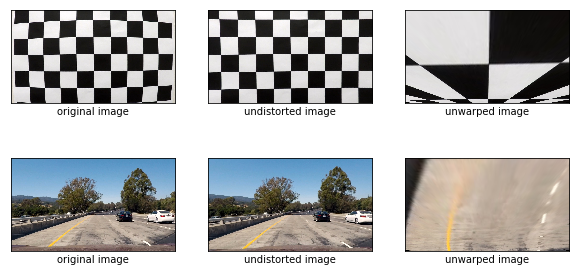

In [7]:
#lets check if the function is working properly or not
#img3 = cv2.imread('test_images/test1.jpg')
warped_img_1 , Transform_matrix ,  Inverse_Transform_Matrix =  Perpective_transform(undist_img1)
warped_img_2 , Transform_matrix ,  Inverse_Transform_Matrix =  Perpective_transform(undist_img2)
plt.figure(figsize=(10,5))
plt.subplot(2,3, 1)
plt.imshow(img1)
plt.xlabel('original image')
plt.xticks([], [])
plt.yticks([], [])
plt.subplot(2,3,2)
plt.imshow(undist_img1)
plt.xlabel('undistorted image')
plt.xticks([], [])
plt.yticks([], [])
plt.subplot(2,3,3)
plt.imshow(warped_img_1)
plt.xlabel('unwarped image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(2,3, 4)
plt.imshow(img2)
plt.xlabel('original image')
plt.xticks([], [])
plt.yticks([], [])
plt.subplot(2,3,5)
plt.imshow(undist_img2)
plt.xlabel('undistorted image')
plt.xticks([], [])
plt.yticks([], [])
plt.subplot(2,3,6)
plt.imshow(warped_img_2)
plt.xlabel('unwarped image')
plt.xticks([], [])
plt.yticks([], [])

plt.show()

In [8]:
#great I think the function is doing its Job, Lets continue forward

In [9]:
#Lets experiement with Colorspaces (HLS)

In [10]:
#we need to find the Lane Lines so, lets use the unwarped image...
R = warped_img_2[:,:,0]
G = warped_img_2[:,:,1]
B = warped_img_2[:,:,2]

img2_hsv = cv2.cvtColor(warped_img_2, cv2.COLOR_RGB2HSV)
H = img2_hsv[:,:,0]
S = img2_hsv[:,:,1]
V = img2_hsv[:,:,2]

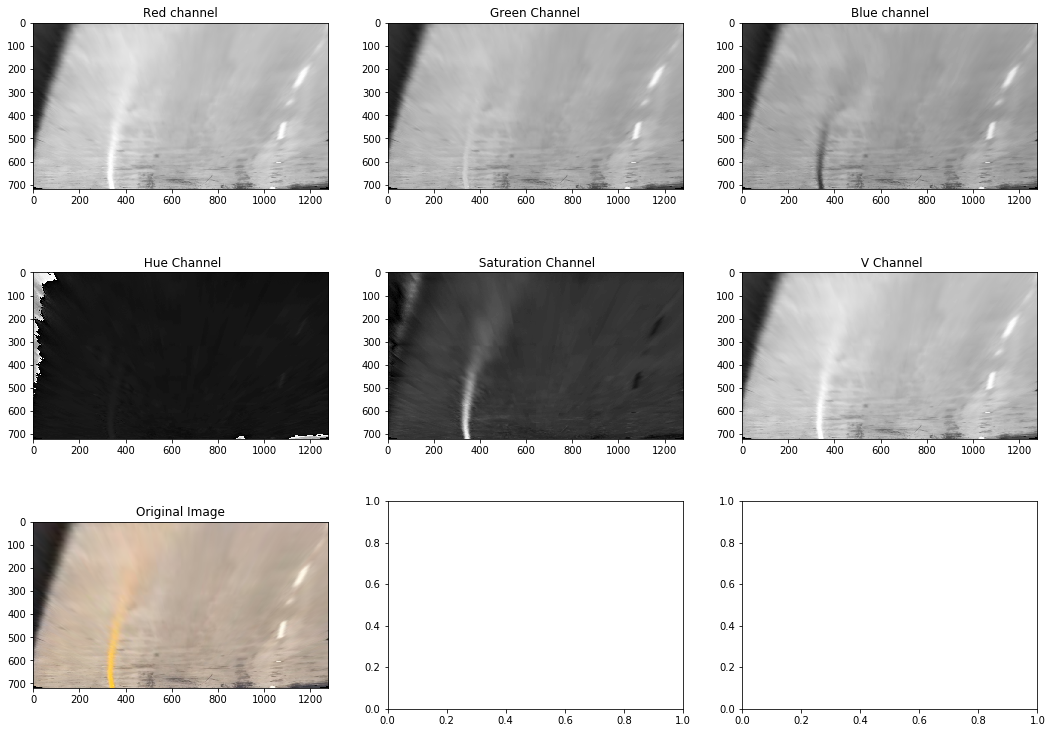

In [11]:
fig, axs = plt.subplots(3,3, figsize=(18, 13))
axs = axs.ravel()
axs[0].imshow(R, cmap='gray')
axs[0].set_title('Red channel')
axs[1].imshow(G, cmap='gray')
axs[1].set_title('Green Channel')
axs[2].imshow(B, cmap='gray')
axs[2].set_title('Blue channel')
axs[3].imshow( H, cmap='gray')
axs[3].set_title(' Hue Channel')
axs[4].imshow( S, cmap='gray')
axs[4].set_title(' Saturation Channel')
axs[5].imshow( V, cmap='gray')
axs[5].set_title(' V Channel')
axs[6].imshow( warped_img_2)
axs[6].set_title('Original Image')

In [12]:
#Now Time to apply Sobel Threshold.....
def Sobel_thresh(img, orient = 'x' , min_thresh = 0 , max_thresh = 255 ):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel = cv2.Sobel(img, cv2.CV_64F, orient == 'x' , orient == 'y')
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= min_thresh) & (scaled_sobel <= max_thresh)] = 1
    return binary_output

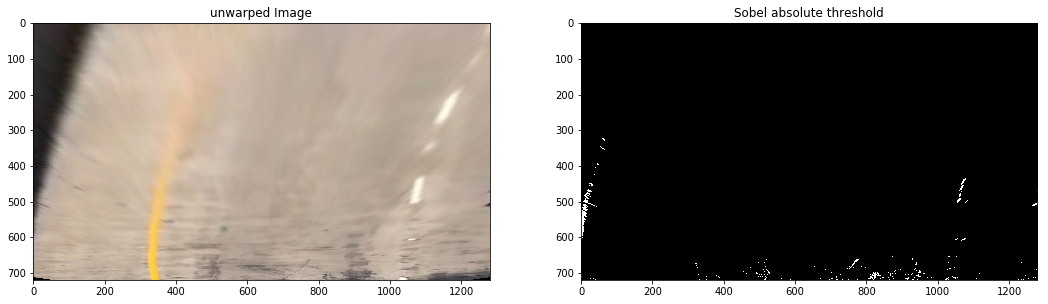

In [13]:
#Now lets see if its working or not...
sobel_img_thresh  = Sobel_thresh(warped_img_2,'x',30,100)
fig, axs = plt.subplots(1,2, figsize=(18, 13))
axs = axs.ravel()
axs[0].imshow(warped_img_2)
axs[0].set_title('unwarped Image')
axs[1].imshow(sobel_img_thresh, cmap='gray')
axs[1].set_title('Sobel absolute threshold')

In [14]:
#ok not bad...let see what more we can do
def magnitude_sobel_threshold(img,kszie = 13 , thresh = (30,100)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1,0)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0,1)
    magnitude_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*magnitude_sobel/np.max(magnitude_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

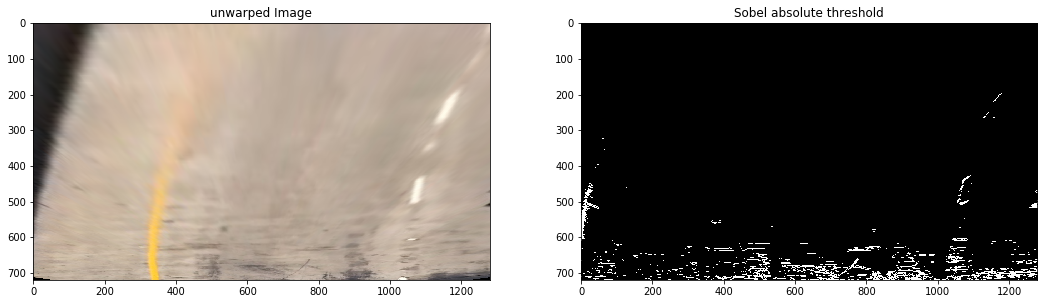

In [15]:
#Now lets see if its working or not...
sobel_img_thresh  = magnitude_sobel_threshold(warped_img_2,13,(15,80))
fig, axs = plt.subplots(1,2, figsize=(18, 13))
axs = axs.ravel()
axs[0].imshow(warped_img_2)
axs[0].set_title('unwarped Image')
axs[1].imshow(sobel_img_thresh, cmap='gray')
axs[1].set_title('Sobel absolute threshold')

In [16]:
#Lets Try Directional threshold
def Sobel_directonal(img, ksize = 13 ,thresh =(0,(np.pi)/2)):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1,0)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0,1)
        sobelx_abs = np.absolute(sobelx)
        sobely_abs = np.absolute(sobely)
        dir_grad = np.arctan2(sobely_abs,sobelx_abs)
        binary_output = np.zeros_like(dir_grad)
        binary_output[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1
        return binary_output

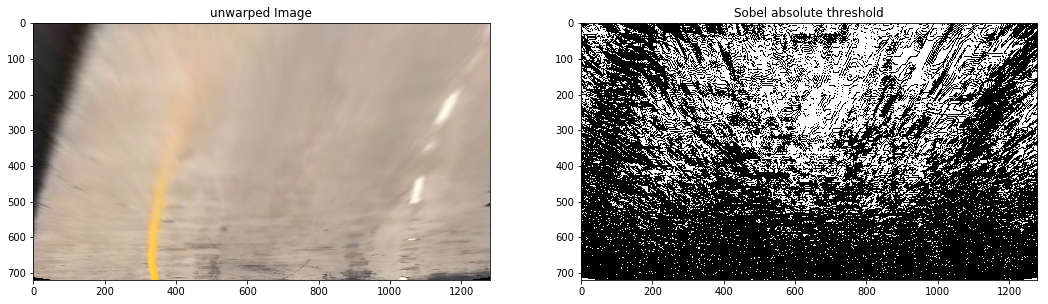

In [17]:
#Now lets see if its working or not...
sobel_img_thresh  = Sobel_directonal(warped_img_2,13,(0,0.09))
fig, axs = plt.subplots(1,2, figsize=(18, 13))
axs = axs.ravel()
axs[0].imshow(warped_img_2)
axs[0].set_title('unwarped Image')
axs[1].imshow(sobel_img_thresh, cmap='gray')
axs[1].set_title('Sobel absolute threshold')

In [18]:
#Lets Combine the magniude and directional threshold.....
def combine_mag_and_dir(img1,img2):
    result  = np.zeros_like(img1)
    result[(img1==1) & (img2==1)] = 1
    return result

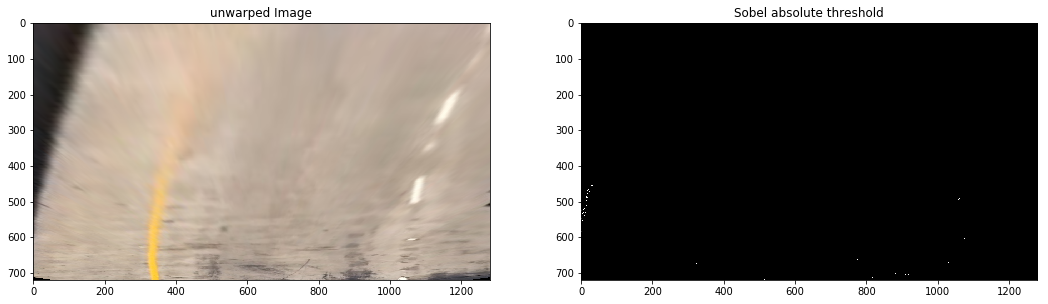

In [19]:
#Now lets see if its working or not...
sobel_img_1  = Sobel_directonal(warped_img_2,13,(0,0.09))
sobel_img_2  = magnitude_sobel_threshold(warped_img_2,13,(15,80))
combined_img = combine_mag_and_dir(sobel_img_1,sobel_img_2)
fig, axs = plt.subplots(1,2, figsize=(18, 13))
axs = axs.ravel()
axs[0].imshow(warped_img_2)
axs[0].set_title('unwarped Image')
axs[1].imshow(combined_img, cmap='gray')
axs[1].set_title('Sobel absolute threshold')

In [20]:
#This looks good as we can see all the noises are eliminated, now lets start 

In [21]:
#Now lets do S channel Thresholding....
def s_thresh(img,thresh=(30,100)):
    hls  = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    binary_output = np.zeros_like(s)
    binary_output[(s>= thresh[0]) & (s<= thresh[1])] = 1
    return binary_output

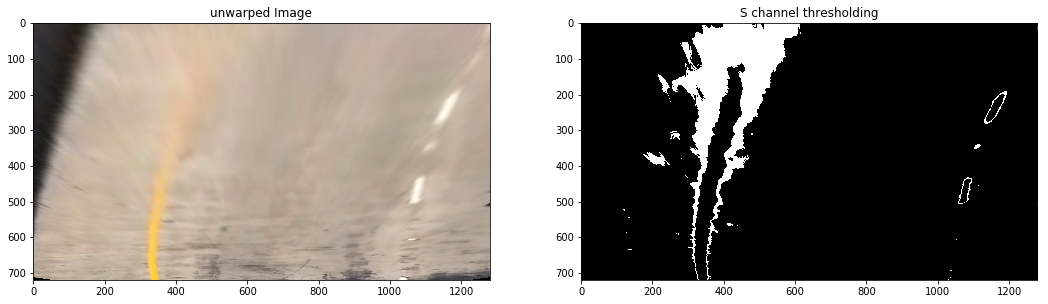

In [22]:
#Now lets see if its working or not...
s_thresh_img = s_thresh(warped_img_2, (85,120))
fig, axs = plt.subplots(1,2, figsize=(18, 13))
axs = axs.ravel()
axs[0].imshow(warped_img_2)
axs[0].set_title('unwarped Image')
axs[1].imshow(s_thresh_img, cmap='gray')
axs[1].set_title('S channel thresholding')

In [23]:
#let now use white and yellow mask in HLS to get better white and yellow results...

def thresh(img,thresh=(20,255)):
    output_binary = np.zeros_like(img)
    output_binary[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return output_binary

def mask_threshold(img):
    hls  = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    '''
    l = np.array([255,180,0], dtype = 'uint8')
    u = np.array([255,255,170], dtype = 'uint8')
    yellow_mask = cv2.inRange(img,l,u)
    yellow_img = cv2.bitwise_and(img,img,mask = yellow_mask).astype(np.uint8)
    yellow_img = cv2.cvtColor(yellow_img , cv2.COLOR_BGR2GRAY)
    
    #white mask
    l = np.array([100,100,200], dtype = 'uint8')
    u = np.array([255,255,255], dtype = 'uint8')
    white_mask = cv2.inRange(img,l,u)
    white_img = cv2.bitwise_and(img,img,mask = white_mask).astype(np.uint8)
    white_img = cv2.cvtColor(white_img , cv2.COLOR_BGR2GRAY)
    '''
    #Yellow HLS  mask
    l = np.array([20,120,80], dtype = 'uint8')
    u = np.array([45,200,255], dtype = 'uint8')
    hls_yellow_mask = cv2.inRange(hls,l,u)
    hls_yellow_img = cv2.bitwise_and(img,img,mask = hls_yellow_mask).astype(np.uint8)
    hls_yellow_img = cv2.cvtColor(hls_yellow_img , cv2.COLOR_HLS2RGB)
    hls_yellow_img = cv2.cvtColor(hls_yellow_img , cv2.COLOR_RGB2GRAY)
    
    #White HLS  mask
    l = np.array([0,210,0], dtype = 'uint8')
    u = np.array([255,255,255], dtype = 'uint8')
    hls_white_mask = cv2.inRange(hls,l,u)
    hls_white_img = cv2.bitwise_and(img,img,mask = hls_white_mask).astype(np.uint8)
    hls_white_img = cv2.cvtColor(hls_white_img , cv2.COLOR_HLS2RGB)
    hls_white_img = cv2.cvtColor(hls_white_img , cv2.COLOR_RGB2GRAY)
    
    
    
    #yellow_img = thresh(yellow_img,(20,255))
    #white_img = thresh(white_img,(20,255))
    hls_yellow_img = thresh(hls_yellow_img , (20,255))
    hls_white_img = thresh(hls_white_img , (20,255))
    binary_output = np.zeros_like(hls_yellow_img)
    binary_output [(hls_white_img ==1)| (hls_yellow_img ==1)] = 1
    '''
    fig, axs = plt.subplots(4,1, figsize=(18, 13))
    axs = axs.ravel()
    axs[0].imshow(yellow_img)
    axs[1].imshow(white_img)
    axs[2].imshow(hls_yellow_img)
    axs[3].imshow(binary_output)
    '''
    return binary_output

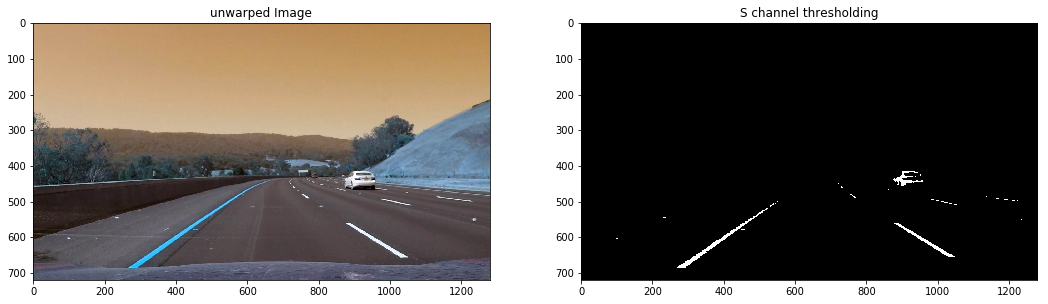

In [24]:
#Now lets see if its working or not...
thresh_img = mask_threshold(cv2.imread('test_images/test3.jpg'))
fig, axs = plt.subplots(1,2, figsize=(18, 13))
axs = axs.ravel()
axs[0].imshow(cv2.imread('test_images/test3.jpg'))
axs[0].set_title('unwarped Image')
axs[1].imshow(thresh_img, cmap='gray')
axs[1].set_title('S channel thresholding')

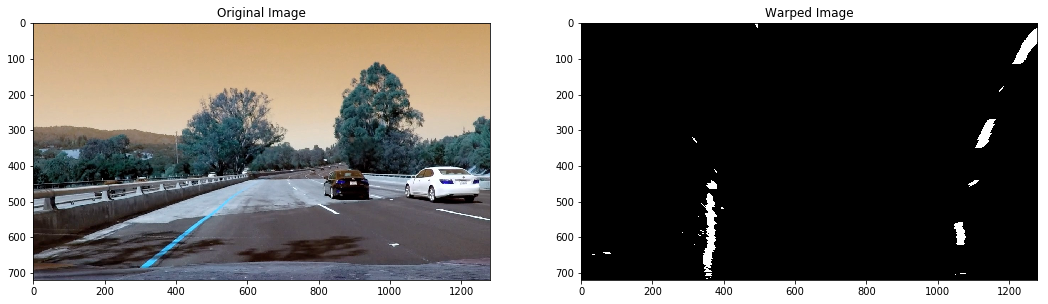

In [25]:
#Its working perfectly lets move on,lets apply perspective transform on it....
img = cv2.imread('test_images/test4.jpg')
undist_img = cv2.undistort(img, mtx , dist,None , mtx)
img_1 = mask_threshold(undist_img)
warped_img , Transform_matrix ,  Inverse_Transform_Matrix =  Perpective_transform(img_1)
fig, axs = plt.subplots(1,2, figsize=(18, 13))
axs = axs.ravel()
axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[1].imshow(warped_img, cmap='gray')
axs[1].set_title('Warped Image')

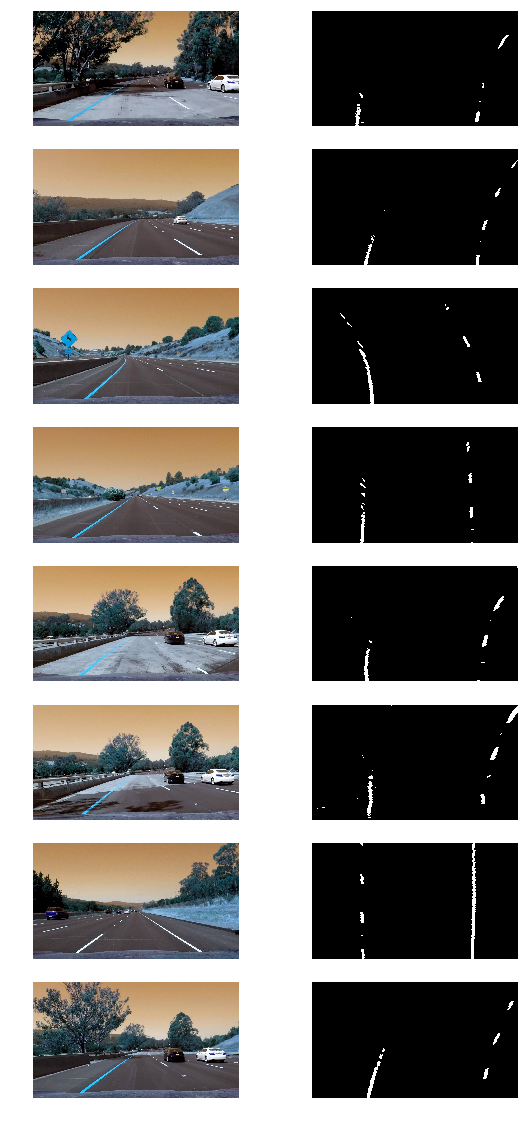

In [26]:
#its look great now lets define a pipeline....
def pipeline(img , mtx , dist):
    undist_img = cv2.undistort(img, mtx , dist,None , mtx)
    thresholded_img = mask_threshold(undist_img)
    warped_img , Transform_matrix ,  Inverse_Transform_Matrix =  Perpective_transform(thresholded_img)
    return warped_img

images = glob.glob('./test_images/*.jpg')                                          
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
k = 0
for image in images:
    img = cv2.imread(image)
    img_processed = pipeline(img , mtx , dist)
    axs[k].imshow(img)
    axs[k].axis('off')
    k += 1
    axs[k].imshow(img_processed, cmap='gray')
    axs[k].axis('off')
    k += 1


In [27]:
#Yes it looks great, now we need to use the sliding window technique to fiind the lane lines.

(720, 0)

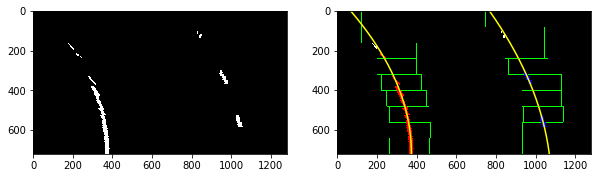

In [28]:
img = cv2.imread('test_images/test2.jpg')
warped_img = pipeline(img , mtx , dist)
#print (warped_img.shape[0]/2)
#plt.imshow(warped_img[int(warped_img.shape[0]/2):,:])

#Lets start with Histogram
mid_y = int(warped_img.shape[0]/2)
histogram = np.sum(warped_img[mid_y:,:],axis = 0) #Histogram of only bottom half of the warped image
out_img = np.dstack((warped_img , warped_img , warped_img))*255 #Image for visulization...

#finding the basepoints of lane in the right and left halves
midpt = np.int(histogram.shape[0]/2)
left_b  = np.argmax(histogram[:midpt])
right_b = np.argmax(histogram[midpt:]) + midpt

#No of Sliding window, the lectures suggested to go with 9
n_window = 9
w_height = np.int(warped_img.shape[0]/n_window) #height of the window...

#we need to identify the pixels where the lanes are present..
non_zero = warped_img.nonzero()
non_zero_y = np.array(non_zero[0])
non_zero_x = np.array(non_zero[1])

#position of each window
left_current = left_b
right_current = right_b
margin  =  100 #the margin where to search...
min_pix = 50 #minimum no of pixel to found to recenter the window...
left_lane_pts  = []
right_lane_pts = []
for window in range(n_window):
    #we need to fisrt identify the windows boundary...
    #we just need 2 y values but 4 x values.
    window_y_low  = warped_img.shape[0] - (window+1)*w_height
    window_y_high = warped_img.shape[0] - (window)*w_height
    window_x_left_low  = left_current - margin
    window_x_left_high = left_current + margin
    window_x_right_low = right_current - margin
    window_x_right_high= right_current + margin
    
    
    
    #Get the nonzero pixels from the window...
    left_pt = ((non_zero_y >= window_y_low) & (non_zero_y < window_y_high) & (non_zero_x >= window_x_left_low) & (non_zero_x < window_x_left_high)).nonzero()[0]
    right_pt = ((non_zero_y >= window_y_low) & (non_zero_y < window_y_high) & (non_zero_x >= window_x_right_low) & (non_zero_x < window_x_right_high)).nonzero()[0]
    
    left_lane_pts.append(left_pt)
    right_lane_pts.append(right_pt)
   
    #visulaizing the windows on the image....
    cv2.rectangle(out_img , (window_x_left_low, window_y_low) , (window_x_left_high, window_y_high) ,(0,255,0),2)
    cv2.rectangle(out_img , (window_x_right_low, window_y_low) , (window_x_right_high, window_y_high) ,(0,255,0),2)
    
    #Now recenter the window on the mean position of the pixel...
    if ( len(left_pt) > min_pix ):
        left_current = np.int(np.mean(non_zero_x[left_pt]))
    if ( len(right_pt) > min_pix ):
        right_current = np.int(np.mean(non_zero_x[right_pt]))

#Now lets find out the right and left lane pixels positions        
left_lane_pts  = np.concatenate(left_lane_pts)
right_lane_pts = np.concatenate(right_lane_pts)
left_lane_x = non_zero_x[left_lane_pts]
left_lane_y = non_zero_y[left_lane_pts]
right_lane_x = non_zero_x[right_lane_pts]
right_lane_y = non_zero_y[right_lane_pts]


#we need to fit a second order polynomial to the pixels
left_lane  = np.polyfit(left_lane_y , left_lane_x ,2 )
right_lane = np.polyfit(right_lane_y , right_lane_x ,2 )


## Lets now Visulaize....
plot_y = np.linspace(0, warped_img.shape[0] - 1 , warped_img.shape[0])
left_lane_fit = left_lane[0]*plot_y**2 + left_lane[1]*plot_y + left_lane[2]
right_lane_fit = right_lane[0]*plot_y**2 + right_lane[1]*plot_y + right_lane[2]

out_img[non_zero_y[left_lane_pts] , non_zero_x[left_lane_pts]] = [255,0,0]
out_img[non_zero_y[right_lane_pts] , non_zero_x[right_lane_pts]] = [0,0,255]


plt.figure(figsize = (10,40))
plt.subplot(1,2,1)
plt.imshow(warped_img, cmap = 'gray')

plt.subplot(1,2,2)
plt.imshow(out_img, cmap = 'gray')
plt.plot(left_lane_fit, plot_y ,color = 'yellow' )
plt.plot(right_lane_fit , plot_y ,color ='yellow')
plt.xlim(0,1280)
plt.ylim(720,0)

(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)


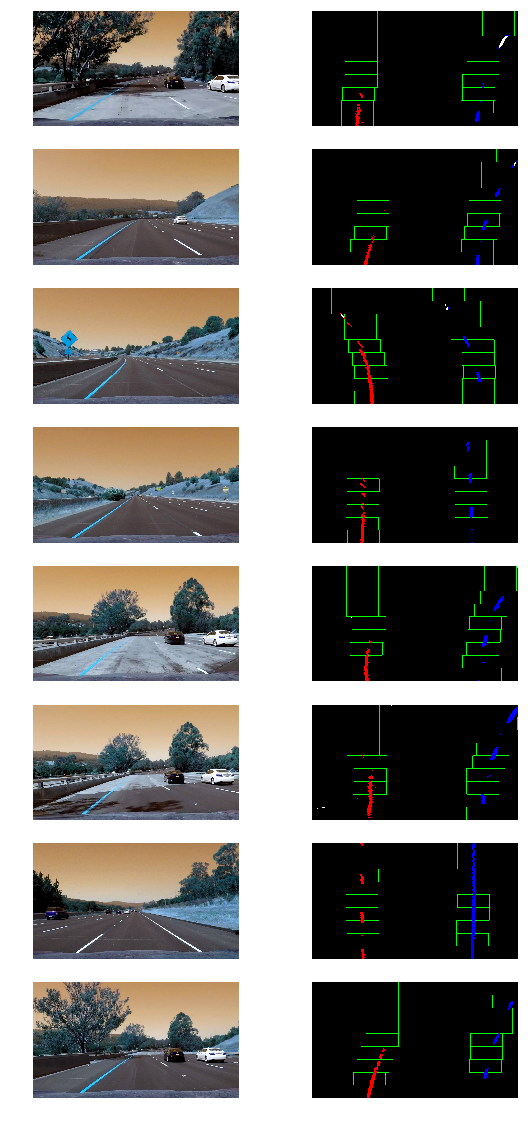

In [29]:
#well now lets check it for very image....
def pipeline(img , mtx , dist):
    undist_img = cv2.undistort(img, mtx , dist,None , mtx)
    thresholded_img = mask_threshold(undist_img)
    warped_img , Transform_matrix ,  Inverse_Transform_Matrix =  Perpective_transform(thresholded_img)
    #Lets start with Histogram
    print (warped_img.shape)
    mid_y = int(warped_img.shape[0]/2)
    histogram = np.sum(warped_img[mid_y:,:],axis = 0) #Histogram of only bottom half of the warped image
    out_img = np.dstack((warped_img , warped_img , warped_img))*255 #Image for visulization...

    #finding the basepoints of lane in the right and left halves
    midpt = np.int(histogram.shape[0]/2)
    left_b  = np.argmax(histogram[:midpt])
    right_b = np.argmax(histogram[midpt:]) + midpt

    #No of Sliding window, the lectures suggested to go with 9
    n_window = 9
    w_height = np.int(warped_img.shape[0]/n_window) #height of the window...

    #we need to identify the pixels where the lanes are present..
    non_zero = warped_img.nonzero()
    non_zero_y = np.array(non_zero[0])
    non_zero_x = np.array(non_zero[1])

    #position of each window
    left_current = left_b
    right_current = right_b
    margin  =  100 #the margin where to search...
    min_pix = 50 #minimum no of pixel to found to recenter the window...
    left_lane_pts  = []
    right_lane_pts = []
    for window in range(n_window):
        #we need to fisrt identify the windows boundary...
        #we just need 2 y values but 4 x values.
        window_y_low  = warped_img.shape[0] - (window+1)*w_height
        window_y_high = warped_img.shape[0] - (window)*w_height
        window_x_left_low  = left_current - margin
        window_x_left_high = left_current + margin
        window_x_right_low = right_current - margin
        window_x_right_high= right_current + margin



        #Get the nonzero pixels from the window...
        left_pt = ((non_zero_y >= window_y_low) & (non_zero_y < window_y_high) & (non_zero_x >= window_x_left_low) & (non_zero_x < window_x_left_high)).nonzero()[0]
        right_pt = ((non_zero_y >= window_y_low) & (non_zero_y < window_y_high) & (non_zero_x >= window_x_right_low) & (non_zero_x < window_x_right_high)).nonzero()[0]

        left_lane_pts.append(left_pt)
        right_lane_pts.append(right_pt)

        #visulaizing the windows on the image....
        cv2.rectangle(out_img , (window_x_left_low, window_y_low) , (window_x_left_high, window_y_high) ,(0,255,0),2)
        cv2.rectangle(out_img , (window_x_right_low, window_y_low) , (window_x_right_high, window_y_high) ,(0,255,0),2)

        #Now recenter the window on the mean position of the pixel...
        if ( len(left_pt) > min_pix ):
            left_current = np.int(np.mean(non_zero_x[left_pt]))
        if ( len(right_pt) > min_pix ):
            right_current = np.int(np.mean(non_zero_x[right_pt]))

    #Now lets find out the right and left lane pixels positions        
    left_lane_pts  = np.concatenate(left_lane_pts)
    right_lane_pts = np.concatenate(right_lane_pts)
    left_lane_x = non_zero_x[left_lane_pts]
    left_lane_y = non_zero_y[left_lane_pts]
    right_lane_x = non_zero_x[right_lane_pts]
    right_lane_y = non_zero_y[right_lane_pts]


    #we need to fit a second order polynomial to the pixels
    left_lane  = np.polyfit(left_lane_y , left_lane_x ,2 )
    right_lane = np.polyfit(right_lane_y , right_lane_x ,2 )


    ## Lets now Visulaize....
    plot_y = np.linspace(0, warped_img.shape[0] - 1 , warped_img.shape[0])
    left_lane_fit = left_lane[0]*plot_y**2 + left_lane[1]*plot_y + left_lane[2]
    right_lane_fit = right_lane[0]*plot_y**2 + right_lane[1]*plot_y + right_lane[2]

    out_img[non_zero_y[left_lane_pts] , non_zero_x[left_lane_pts]] = [255,0,0]
    out_img[non_zero_y[right_lane_pts] , non_zero_x[right_lane_pts]] = [0,0,255]
    return out_img

images = glob.glob('./test_images/*.jpg')                                          
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
k = 0
for image in images:
    img = cv2.imread(image)
    img_processed = pipeline(img , mtx , dist)
    axs[k].imshow(img)
    axs[k].axis('off')
    k += 1
    axs[k].imshow(img_processed, cmap='gray')
    axs[k].axis('off')
    k += 1

In [30]:
#It looks great.....:)
#Now lets calculate the radius of curvature....
x_m_pixel = 3.7 / 660.0 #meter per pixel in x
y_m_pixel = 3.7 / 72.0  #meter per pixel in y

y_1 = (2*left_lane[0]*700 + left_lane[1])*x_m_pixel/y_m_pixel
y_2 = (2*left_lane[0]*x_m_pixel)/(y_m_pixel*y_m_pixel)
curvature = ((1 + y_1*y_1)**(1.5))/np.absolute(y_2)
#print (curvature)

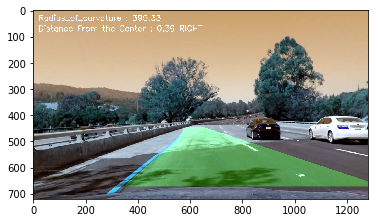

In [31]:
#Great now we have to plot back the lanes on the images.....
plot_y = np.linspace(0, warped_img.shape[0]-1 ,warped_img.shape[0])
left_lane_fit = left_lane[0]*plot_y**2  + left_lane[1]*plot_y + left_lane[2]
right_lane_fit  = right_lane[0]*plot_y*2 + right_lane[1]*plot_y + right_lane[2]

#create a color zero image
w_zero = np.zeros_like(warped_img).astype(np.uint8)
color_warp = np.dstack((w_zero, w_zero, w_zero))

point_left = np.array([np.transpose(np.vstack([left_lane_fit,plot_y]))])
point_right = np.array([np.flipud(np.transpose(np.vstack([right_lane_fit, plot_y])))])
points = np.hstack((point_left,point_right))


#Drawing the lane line on the warped blank Image
cv2.fillPoly(color_warp, np.int_([points]),(0,255,0))

#now we need to transform it to original..
tras_img = cv2.warpPerspective(color_warp,Inverse_Transform_Matrix , (undist_img.shape[1],undist_img.shape[0]))
final_img =cv2.addWeighted(undist_img, 1 , tras_img , 0.3,0)


#Now lets put some text in the image.....
cv2.putText(final_img, 'Radius_of_curvature : %.2f' %curvature, (20,40), cv2.FONT_HERSHEY_SIMPLEX,1 ,(255,255,255),2)

#now lets calculate distance from the center...
left_pix = left_lane[0]*700**2 + left_lane[1]*700 + left_lane[2]
right_pix = right_lane[0]*700**2 + right_lane[1]*700 + right_lane[2]
center = ( (left_pix + right_pix )/2 - 650 )*x_m_pixel
#Now
if center > 0 :
    txt  = 'RIGHT'
else:
    txt  = 'LEFT'
    
cv2.putText(final_img , 'Distance From the Center : %.2f %s' %(np.absolute(center), txt) ,(20,80),cv2.FONT_HERSHEY_SIMPLEX , 1 ,(255,255,255),2)
plt.imshow(final_img)

(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)


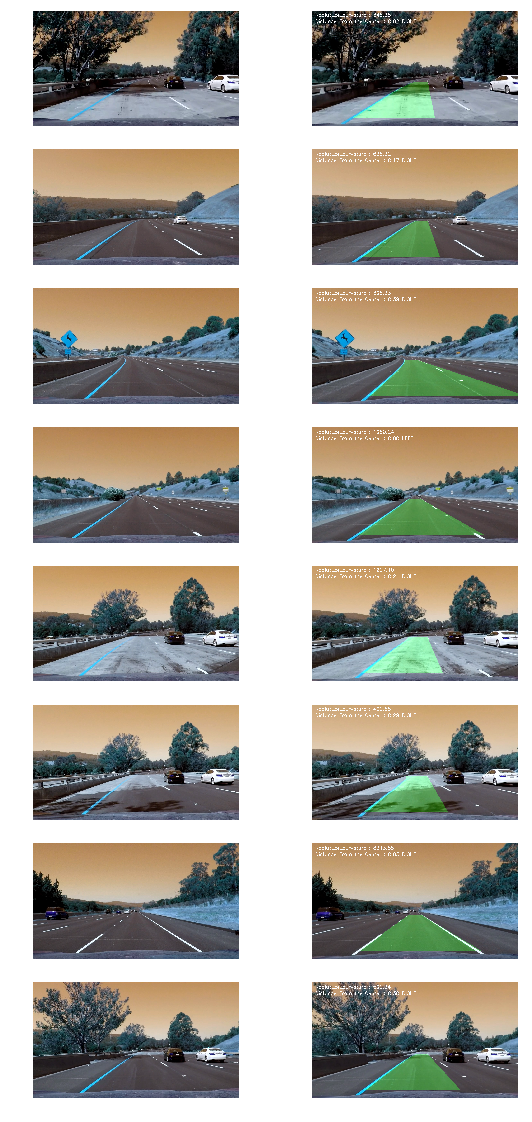

In [32]:
#Lets get the whole pipeline
#well now lets check it for very image....
def pipeline(img , mtx , dist):
    undist_img = cv2.undistort(img, mtx , dist,None , mtx)
    thresholded_img = mask_threshold(undist_img)
    warped_img , Transform_matrix ,  Inverse_Transform_Matrix =  Perpective_transform(thresholded_img)
    #Lets start with Histogram
    print (warped_img.shape)
    mid_y = int(warped_img.shape[0]/2)
    histogram = np.sum(warped_img[mid_y:,:],axis = 0) #Histogram of only bottom half of the warped image
    out_img = np.dstack((warped_img , warped_img , warped_img))*255 #Image for visulization...

    #finding the basepoints of lane in the right and left halves
    midpt = np.int(histogram.shape[0]/2)
    left_b  = np.argmax(histogram[:midpt])
    right_b = np.argmax(histogram[midpt:]) + midpt

    #No of Sliding window, the lectures suggested to go with 9
    n_window = 9
    w_height = np.int(warped_img.shape[0]/n_window) #height of the window...

    #we need to identify the pixels where the lanes are present..
    non_zero = warped_img.nonzero()
    non_zero_y = np.array(non_zero[0])
    non_zero_x = np.array(non_zero[1])

    #position of each window
    left_current = left_b
    right_current = right_b
    margin  =  100 #the margin where to search...
    min_pix = 50 #minimum no of pixel to found to recenter the window...
    left_lane_pts  = []
    right_lane_pts = []
    for window in range(n_window):
        #we need to fisrt identify the windows boundary...
        #we just need 2 y values but 4 x values.
        window_y_low  = warped_img.shape[0] - (window+1)*w_height
        window_y_high = warped_img.shape[0] - (window)*w_height
        window_x_left_low  = left_current - margin
        window_x_left_high = left_current + margin
        window_x_right_low = right_current - margin
        window_x_right_high= right_current + margin



        #Get the nonzero pixels from the window...
        left_pt = ((non_zero_y >= window_y_low) & (non_zero_y < window_y_high) & (non_zero_x >= window_x_left_low) & (non_zero_x < window_x_left_high)).nonzero()[0]
        right_pt = ((non_zero_y >= window_y_low) & (non_zero_y < window_y_high) & (non_zero_x >= window_x_right_low) & (non_zero_x < window_x_right_high)).nonzero()[0]

        left_lane_pts.append(left_pt)
        right_lane_pts.append(right_pt)

        #visulaizing the windows on the image....
        cv2.rectangle(out_img , (window_x_left_low, window_y_low) , (window_x_left_high, window_y_high) ,(0,255,0),2)
        cv2.rectangle(out_img , (window_x_right_low, window_y_low) , (window_x_right_high, window_y_high) ,(0,255,0),2)

        #Now recenter the window on the mean position of the pixel...
        if ( len(left_pt) > min_pix ):
            left_current = np.int(np.mean(non_zero_x[left_pt]))
        if ( len(right_pt) > min_pix ):
            right_current = np.int(np.mean(non_zero_x[right_pt]))

    #Now lets find out the right and left lane pixels positions        
    left_lane_pts  = np.concatenate(left_lane_pts)
    right_lane_pts = np.concatenate(right_lane_pts)
    left_lane_x = non_zero_x[left_lane_pts]
    left_lane_y = non_zero_y[left_lane_pts]
    right_lane_x = non_zero_x[right_lane_pts]
    right_lane_y = non_zero_y[right_lane_pts]


    #we need to fit a second order polynomial to the pixels
    left_lane  = np.polyfit(left_lane_y , left_lane_x ,2 )
    right_lane = np.polyfit(right_lane_y , right_lane_x ,2 )


    ## Lets now Visulaize....
    plot_y = np.linspace(0, warped_img.shape[0] - 1 , warped_img.shape[0])
    left_lane_fit = left_lane[0]*plot_y**2 + left_lane[1]*plot_y + left_lane[2]
    right_lane_fit = right_lane[0]*plot_y**2 + right_lane[1]*plot_y + right_lane[2]

    out_img[non_zero_y[left_lane_pts] , non_zero_x[left_lane_pts]] = [255,0,0]
    out_img[non_zero_y[right_lane_pts] , non_zero_x[right_lane_pts]] = [0,0,255]
    
    
    #It looks great.....:)
    #Now lets calculate the radius of curvature....
    x_m_pixel = 3.7 / 660.0 #meter per pixel in x
    y_m_pixel = 3.7 / 72.0  #meter per pixel in y

    y_1 = (2*left_lane[0]*700 + left_lane[1])*x_m_pixel/y_m_pixel
    y_2 = (2*left_lane[0]*x_m_pixel)/(y_m_pixel*y_m_pixel)
    curvature = ((1 + y_1*y_1)**(1.5))/np.absolute(y_2)
    #print (curvature)
    
    #Great now we have to plot back the lanes on the images.....
    plot_y = np.linspace(0, warped_img.shape[0]-1 ,warped_img.shape[0])
    left_lane_fit = left_lane[0]*plot_y**2  + left_lane[1]*plot_y + left_lane[2]
    right_lane_fit  = right_lane[0]*plot_y*2 + right_lane[1]*plot_y + right_lane[2]

    
    #create a color zero image
    w_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((w_zero, w_zero, w_zero))

    point_left = np.array([np.transpose(np.vstack([left_lane_fit,plot_y]))])
    point_right = np.array([np.flipud(np.transpose(np.vstack([right_lane_fit, plot_y])))])
    points = np.hstack((point_left,point_right))


    #Drawing the lane line on the warped blank Image
    cv2.fillPoly(color_warp, np.int_([points]),(0,255,0))

    #now we need to transform it to original..
    tras_img = cv2.warpPerspective(color_warp,Inverse_Transform_Matrix , (undist_img.shape[1],undist_img.shape[0]))
    final_img =cv2.addWeighted(undist_img, 1 , tras_img , 0.3,0)


    #Now lets put some text in the image.....
    cv2.putText(final_img, 'Radius_of_curvature : %.2f' %curvature, (20,40), cv2.FONT_HERSHEY_SIMPLEX,1 ,(255,255,255),2)

    #now lets calculate distance from the center...
    left_pix = left_lane[0]*700**2 + left_lane[1]*700 + left_lane[2]
    right_pix = right_lane[0]*700**2 + right_lane[1]*700 + right_lane[2]
    center = ( (left_pix + right_pix )/2 - 650 )*x_m_pixel
    #Now
    if center > 0 :
        txt  = 'RIGHT'
    else:
        txt  = 'LEFT'

    cv2.putText(final_img , 'Distance From the Center : %.2f %s' %(np.absolute(center), txt) ,(20,80),cv2.FONT_HERSHEY_SIMPLEX , 1 ,(255,255,255),2)
    return (final_img)

images = glob.glob('./test_images/*.jpg')                                          
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
k = 0
for image in images:
    img = cv2.imread(image)
    img_processed = pipeline(img , mtx , dist)
    axs[k].imshow(img)
    axs[k].axis('off')
    k += 1
    axs[k].imshow(img_processed, cmap='gray')
    axs[k].axis('off')
    k += 1

In [33]:
#Lets do it on video now....
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [34]:
from lane_finder import lane_finder

In [35]:
from line import Line

In [36]:
line = Line()

In [37]:
lane_finder.intialise_matrix(line,Transform_matrix,Inverse_Transform_Matrix,mtx,dist)

In [38]:
output = 'video_output.mp4'

In [39]:
clip = VideoFileClip("project_video.mp4")

In [40]:
img = lane_finder.lane_finder_pipeline(cv2.imread('test_images/test2.jpg'))

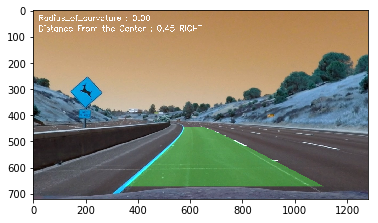

In [41]:
plt.imshow(img)

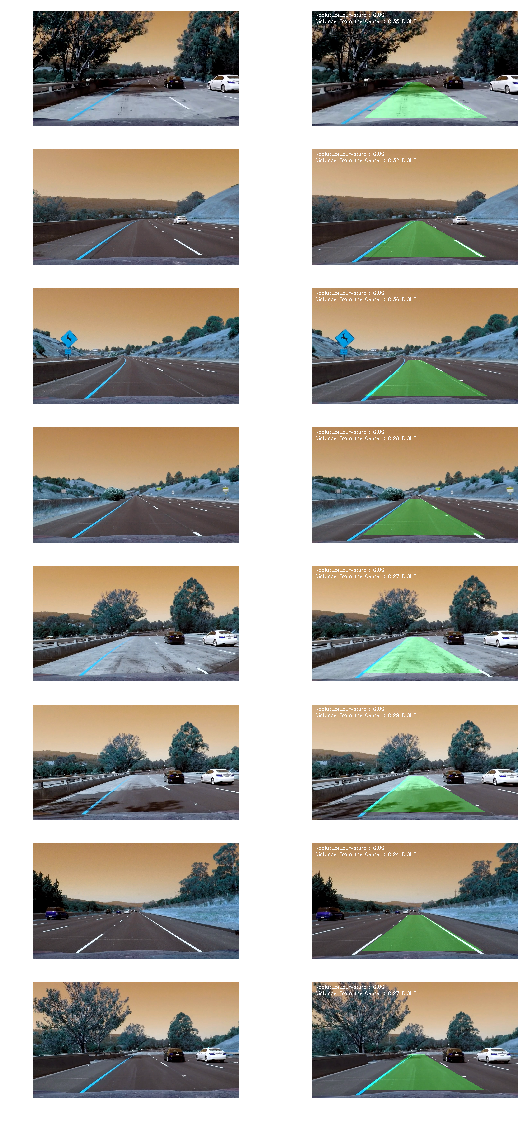

In [42]:
images = glob.glob('./test_images/*.jpg')                                          
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
k = 0
for image in images:
    img = cv2.imread(image)
    img_processed = lane_finder.lane_finder_pipeline(img)
    axs[k].imshow(img)
    axs[k].axis('off')
    k += 1
    axs[k].imshow(img_processed, cmap='gray')
    axs[k].axis('off')
    k += 1

In [43]:
output = 'video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(lane_finder.lane_finder_pipeline)
%time clip.write_videofile(output,audio=False)

TypeError: expected non-empty vector for x

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [ ]:
#looks good ....finally over :)